# Кластеризация.

[Кластеризация](https://ru.wikipedia.org/wiki/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7) - это один из видов задач обучения без учителя. Задача заключается в разбиении всех объектов на группы похожих между собой объектов и сильно отличающихся от всех остальных. Так как строгого понятия похожести объектов как такового нет, то алгоритмов кластеризации много, да и каждый алгоритм имеет много вариантов работы.

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png)

## KMeans

Метод k-means - это один из наиболее популярных методов кластеризации. Основная идея метода заключается в том, что на каждой итерации пересчитывается центр масс (центроид) для каждого кластера, полученного на предыдущем шаге, затем объекты снова разбиваются на кластеры согласно тому, какой из новых центроидов находится ближе.
Более формально, алгоритм принимает на вход выборку $X_1, \dots, X_N$ и параметр $k$, указывающий необходимое число кластеров. Выходом алгоритма является набор из $k$ центроидов $\{\mu_1, \dots, \mu_k\}$, с помощью которых кластеризация осуществляется путём отнесения каждого объекту к ближайшему центроиду. Все точки внутри одного кластера ближе к центроиду этого кластера, чем к центроиду любого другого кластера.
Метод может быть сформулирован как задача оптимизации, а именно, минимизации суммарного квадратичного отклонения точек кластеров от центров этих кластеров по центроидам и кластерам: $$\sum_{i=1}^k \sum_{X_n \in C_i} ||X_n - \mu_i||^2 \rightarrow \min, \text{где $C_i$ - это $i$-ый кластер, $\mu_i$ - это центр масс кластера $C_i$.}$$
Решение такой задачи оптимизации является NP-трудной задачей, однако существует простой итеративный алгоритм, позволяющий найти локальный минимум указанного функционала. Алгоритм представляет собой последовательное чередование двух шагов до сходимости.
Предположим, что как-то (например, случайно) выбраны начальные положения центроидов $\mu_1, \dots, \mu_k$.

1. Этап кластеризации. На данном этапе происходит кластеризация выборки, как было описано выше: каждый объект относится к кластеру ближайшего к нему центроида. Формально, $$C_i = \{X_n : ||X_n - \mu_i|| \leq ||X_n - \mu_j||, \text{ для всех $j \in \{1, \dots, k\}$}\}.$$

2. Этап обновления центроидов. На данном этапе центроиды пересчитываются, как центры масс только что построенных кластеров. Формально, $$\mu_i = \frac{1}{|C_i|}\sum_{X_n \in C_i} X_n.$$

Этот процесс продолжается, пока центроиды и кластеризация продолжают изменяться. Алгоритм гарантированно сходится, однако не гарантируется достижение глобального минимума, а только одного из локальных минимумов. Другим недостатком алгоритма является то, что итоговая кластеризация зависит от выбора исходных центров кластеров. На практике алгоритм запускается несколько раз из различных начальных приближений, а полученные результаты некоторым образом усредняются. Стоит также отметить, что число кластеров необходимо знать заранее. Существуют различные эвристики, позволяющие выбирать в некотором смысле оптимальное число кластеров.

_определение взято из материалов курса [ODS](https://habrahabr.ru/company/ods/)_

### Литература

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random 
from tqdm.notebook import tqdm
from skimage.io import imread

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Рассмотрим как работает алгоритм кластеризации KMeans на синтетическом примере.

Бросим на плоскость случайно точки с разными параметрами случайности, чтобы образовались кластеры.

In [ ]:
p1 = np.random.normal(loc=0, scale=1, size=(50,2))
p2 = np.random.normal(loc=5, scale=2, size=(50,2))
p3 = np.random.normal(loc=10, scale=0.8, size=(50,2)) - np.array([5, -5])

X = np.concatenate((p1, p2, p3))

plt.scatter(p1[:,0], p1[:, 1])
plt.scatter(p2[:,0], p2[:, 1])
plt.scatter(p3[:,0], p3[:, 1])

Нарисуем точки на плоскости, но без окрашивания точек. Так будет видеть данные алгоритм. Можем ли мы сами понять где и какие кластеры?

In [ ]:
plt.scatter(X[:, 0], X[:, 1])

Рассмотрим пошагово работу алгоритма KMneans на основе обычного евклидова расстояния.  

_Пример из блога ODS: https://habrahabr.ru/company/ods/blog/325654/_

### Задание 1.1 
Напишите функцию, которая рассчитывает расстояния от центров кластеров до каждой точки и возвращает, к какому кластеру принадлежит каждая точка.

In [ ]:
def kmeans_predict(x, clusters):
    labels = []
    
    #################
    #    Ваш код    #
    #################

    #HINT
    # Считаем расстояния от наблюдений до центроид
    # Смотрим, до какой центроиды каждой точке ближе всего (np.argmin)

    return labels

# В scipy есть замечательная функция, которая считает расстояния
# между парами точек из двух массивов, подающихся ей на вход
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
# Это сократит кол-во for и из-за этого код будет работать намного быстрее
# Но так нагляднее

Проверяем что получилось

In [ ]:
# Генерируем случайные координаты для центров кластеров
centroids = np.random.normal(loc=0.0, scale=5., size=6)
centroids = centroids.reshape((3, 2)) # итого получаем 3 точки в двумерном пространстве

plt.figure(figsize=(10, 10))
labels = kmeans_predict(X, centroids)

plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
plt.plot(centroids[:, 0], centroids[:, 1], 'rX')
plt.legend(loc=0)

###  Задание 1.2 
Напишите код для обновления центров кластеров. Запоминайте центры кластеров $-$ это понадобится потом для визуализации.
Для упрощения каждому облачку данных заранее присвоим кластер.<br>
Положим в каждую новую центроиду геометрический центр её точек.<br>

In [ ]:
centroids = np.random.normal(loc=0.0, scale=1., size=6).reshape((3, 2))

cent_history = [] # История центров кластеров
cent_history.append(centroids)

STEPS = 5 # количество шагов итерации обновления центров кластеров

for i in range(STEPS):

    #################
    #    Ваш код    #
    #################

    # HINT 
    # Положим в каждую новую центроиду геометрический центр её точек

    cent_history.append(centroids)

А теперь нарисуем всю эту красоту

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(STEPS + 1):
    labels = kmeans_predict(X, cent_history[i])

    plt.subplot((STEPS + 1) // 2, (STEPS + 1) // 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1))

Обратите внимание, последние 3 шага уже не сильно изменили координаты центров кластеров и состав кластеров.

### 1.3 Напишите функцию обучения kMeans, которая возвращает центры кластеров и к какому кластеру принадлежит каждая точка. 

* k - кол-во кластеров
* max_iter - через сколько итераций остановится
* tol - если сумма расстояний между прошлыми центрами кластеров и новыми центрами меньше tol, то остановиться
* low и high - это минимально и максимально значение которое могут принимать точки центров кластеров при генерации

In [ ]:
def kmeans_fit_predict(x, k=8, max_iter=100, tol=0.1, low=0.0, high=1.0):
    
    ###########################
    #    Много вашего кода    #
    ###########################

    # сгенерируйте центры кластеров, используя np.random.uniform
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html
    
    # в каждой итерации нужно сделать следующее:
    #  * определить, к какому кластеру относится каждая точка (для этого генерировали центры кластеров)
    #  * по точкам в кластере пересчитываем центр кластера (np.average), если нет точек в кластере - генерируем новый случайный центр 
    #  * считаем loss - сейчас это показатель того, насколько сильно изменилось значение центров кластеров с прошлой итерации
    #  * обычно loss - это показатель того, насколько плохо предсказывает модель, чем он меньше, тем лучше
    #  * loss = |СУММА(полученные_кластеры_на_текущей_итерации - кластеры_на_прошлой_итерации)| 


    # для удобства можно выводить номер итерации и ее loss

    return clusters, labels

Проверим работу на точках: воспользуемся kmeans_fit_predict и построим график для результата предсказания кластеров. 

In [ ]:
# установим число кластеров k равное трем
# не генерируем центр кластера выше максимального значения из Х - ограничим это используя high
clusters_mnist, labels_mnist = kmeans_fit_predict(X, k=3, low=0.0, high=np.max(X))

In [ ]:

plt.figure(figsize=(15, 15))
plt.subplot((STEPS + 1) // 2, (STEPS + 1) // 2, i + 1)
plt.plot(X[labels_mnist == 0, 0], X[labels_mnist == 0, 1], 'bo', label='cluster #1')
plt.plot(X[labels_mnist == 1, 0], X[labels_mnist == 1, 1], 'co', label='cluster #2')
plt.plot(X[labels_mnist == 2, 0], X[labels_mnist == 2, 1], 'mo', label='cluster #3')
plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
plt.legend(loc=0)

## MNIST

Рассмотрим датасет рукописных цифр MNIST, с которым мы уже работали в задании по KNN.



In [ ]:
from sklearn import datasets

X, y = datasets.load_digits(return_X_y=True)

print("Экземпляров: {}\nРазмер изображения: {}x{}".format(X.shape[0], np.sqrt(X.shape[1]), np.sqrt(X.shape[1])))

Экземпляров: 1797
Размер изображения: 8.0x8.0


Подумайте, как можно использовать kmeans для классификации

**Ваш ответ:**


Натренируйте kMeans используя функцию `kmeans_fit_predict()`, выберите high и low (как в примере с точками). Выберите подходящее число кластеров

In [ ]:
clusters_mnist, labels_mnist =  ### ВАШ КОД ###

Итерация = 0 loss = 1044.5370067011513
Итерация = 1 loss = 47.03624356412283
Итерация = 2 loss = 56.920343211488905
Итерация = 3 loss = 15.132667216075829
Итерация = 4 loss = 40.858703980087796
Итерация = 5 loss = 31.271726880560408
Итерация = 6 loss = 48.71951015532781
Итерация = 7 loss = 89.94292131700118
Итерация = 8 loss = 97.74452779282836
Итерация = 9 loss = 77.4763353484769
Итерация = 10 loss = 89.15756183280584
Итерация = 11 loss = 19.91537549701114
Итерация = 12 loss = 23.38125728818858
Итерация = 13 loss = 44.08381178090366
Итерация = 14 loss = 29.500832930965032
Итерация = 15 loss = 7.166397375473707
Итерация = 16 loss = 60.48260132639747
Итерация = 17 loss = 82.9345383416699
Итерация = 18 loss = 97.0424102273324
Итерация = 19 loss = 85.82614653924605
Итерация = 20 loss = 19.468141682107962
Итерация = 21 loss = 0.6974800539545569


Проверим. Выведем 10 точек из какого нибудь кластера и посмотрим, что они соотвествуют одной цифре.

8 8 8 8 8 8 8 8 8 8 

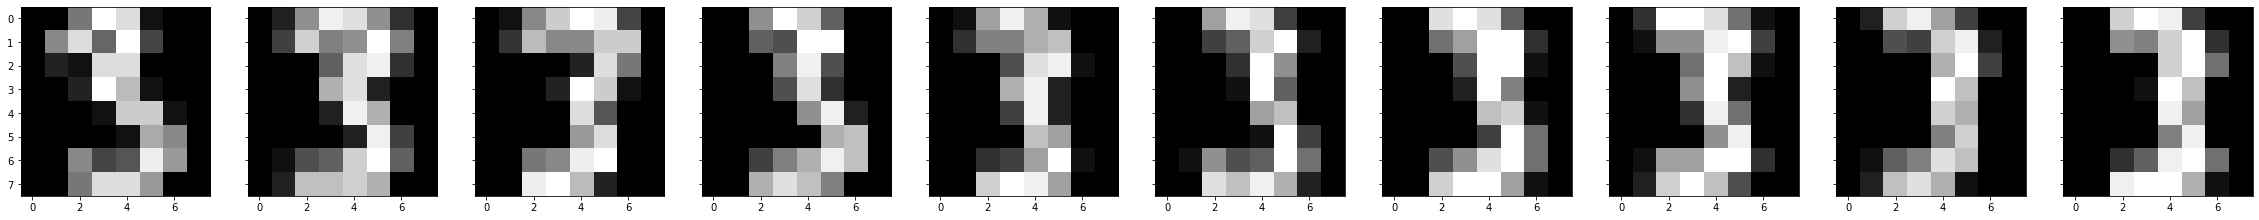

In [ ]:
number = 3 # Номер кластера
count = 10 # Кол-во примеров
testX = X[y == number]

testX[0,:].reshape([8,8])
f, axes = plt.subplots(1, count, sharey=True, figsize=(40,6))
for i in range(count):
    axes[i].imshow(testX[i,:].reshape([8,8]), cmap='gray')

## Центры кластеров фотографий

Можно найти центры кластеров по фотографиям людей.

Возьмем фото 12 разных людей и разобьем их на кластеры. Так можно решать, например, задачу идентификации людей. Можно добавлять новое лицо и, не переобучая kmeans, определять, кто на этой фотографии (к какому кластеру относится картинка).

In [ ]:
# загрузим датасет с фотографиями знаменитостей
from sklearn import datasets
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=50, resize=0.4)

Ariel Sharon: 77 photos.
Colin Powell: 236 photos.
Donald Rumsfeld: 121 photos.
George W Bush: 530 photos.
Gerhard Schroeder: 109 photos.
Hugo Chavez: 71 photos.
Jacques Chirac: 52 photos.
Jean Chretien: 55 photos.
John Ashcroft: 53 photos.
Junichiro Koizumi: 60 photos.
Serena Williams: 52 photos.
Tony Blair: 144 photos.


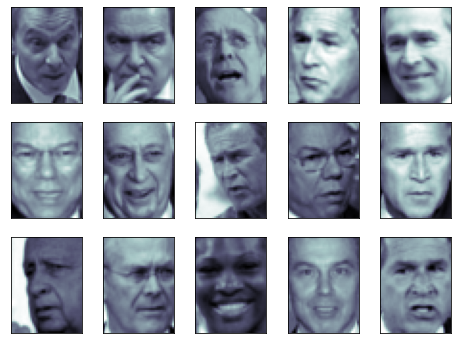

In [ ]:
fig = plt.figure(figsize=(8, 6))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap='bone')

for i, name in enumerate(lfw_people.target_names):
    print("{}: {} photos.".format(name, (lfw_people.target == i).sum()))

### 3.1 Натренируйте kMeans и нарисуйте центры кластеров как картинки выше.

In [ ]:
#################
#    Ваш код    #
#################

## Визуализация 64-мерного пространства, используя PCA и TSNE

Просто так визуализировать 64-мерный объект не получится, нам нужно уменьшить его размерность до 2, чтобы он укладывался на плоскость.

Существует специальный алгоритм PCA - Метод главных компонент.

![](http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png)

Далее мы будем использовать библиотеку [scikit-learn](http://scikit-learn.org/). По сути это библиотека-набор разных алгоритмов анализа данных, машинного обучения.

Документация по библиотеке всегда доступна:
- по ? в jupyter
- по комбинации shift-tab в jupyter
- на сайте http://scikit-learn.org/stable/documentation.html

Просто так визуализировать 64-мерный объект не получится, нам нужно уменьшить его размерность до 2, чтобы он укладывался на плоскость.

Существует специальный алгоритм PCA -  [Метод главных компонент](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82).

Нарисуем scatter plot для тренировочной выборки: на графике у нас будут точки, помеченные лейблом - цифрой которую обозначает эта точка в пространстве.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42) # 2 компоненты, значит 2-мерное представление

X_reduced = pca.fit_transform(X)
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

А теперь посмотрим как расставил границы наш алгоритм KMeans. Как видим - хоть цвета и перепутаны, но сами кластеры угадываются.

In [ ]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels_mnist, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

Центры кластеров представляют из себя нечто среднее, окруженное максимально "похожими" на них элементами. Поэтому мы можем предположить, что на визуализации, центры кластеров будут похожи на цифры.

Центры кластеров можно получить у модели лежат в `clusters_mnist`.

In [ ]:
plt.figure(figsize=(16, 6))

for i, center in enumerate(clusters_mnist):
    plt.subplot(2, 5, i + 1)
    plt.imshow(center[:].reshape([8,8]), cmap='gray')

Существуют и другие методы понижения размерности, например t-SNE, но он намного медленнее чем PCA.

Мы пока что не изучаем как именно работают PCA и tSNE, просто восхтимся их способностями.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=42)
X_reduced_t = tsne.fit_transform(X)

plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

Теперь нарисуем тот же scatter-plot, только на основе лейблов из kMeans. Ожидаем что кластеры будут покрашены в нужные цвета.

In [ ]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=labels_mnist, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()